# Document Classification - HR

In [1]:
# install necessary packages
!pip install -q -r requirements.txt

In [ ]:
# Import necessary libraries and modules
import logging
logger = logging.getLogger('sagemaker')
logger.setLevel(logging.WARNING)
logging.getLogger("sagemaker.config").setLevel(logging.WARNING)

import boto3
import sagemaker
import botocore
from io import BytesIO

import pandas as pd
import numpy as np
import random
import seaborn as sns
import matplotlib.pyplot as plt
import joblib
%matplotlib inline

import os
from utils import prepare_data,rf_model

In [3]:
def load_csv_from_s3(bucket_name, file_key, s3_client):
    obj = s3_client.get_object(Bucket=bucket_name, Key=file_key)
    return pd.read_csv(BytesIO(obj['Body'].read()))

In [4]:
# Initialize S3 client 
s3_client = boto3.client(service_name='s3')
bucket_name = "docu-classification" # identified bucket
print('S3 Bucket: {}'.format(bucket_name))

file_prefix = "data/"
datasets = {}
for filename in ["data", "train_data", "val_data", "test_data"]:
    file_key = f"{file_prefix}{filename}.csv"  
    try:
        datasets[filename] = load_csv_from_s3(bucket_name, file_key, s3_client) #load data file
        print(f"File {filename} loaded.")
    except Exception as e:
        print(f"Error occurred while uploading file: {e}")
        
#implement datasets
data = datasets["data"]
train_data = datasets["train_data"]
val_data = datasets["val_data"]
test_data = datasets["test_data"]

S3 Bucket: docu-classification
File data loaded.
File train_data loaded.
File val_data loaded.
File test_data loaded.


In [5]:
# load utils
file_prefix = "models/"
utils = {}
for util in ["label_encoder", "tfidf_vectorizer"]:
    file_key = f"{file_prefix}{util}.pkl"  
    try:
        obj = s3_client.get_object(Bucket=bucket_name, Key=file_key)
        utils[util] = joblib.load(BytesIO(obj['Body'].read())) #load util file
        print(f"File {util} loaded.")
    except Exception as e:
        print(f"Error occurred while uploading file: {e}")


tfidf_vectorizer = utils["tfidf_vectorizer"]
label_encoder = utils["label_encoder"]

File label_encoder loaded.
File tfidf_vectorizer loaded.


# 1. Model 1: Random Forest

In [8]:
import pickle
from scipy.sparse import vstack

#load optimal hyperparameters after hp tuning
a_file = open("config_hp_rf.pkl", "rb")
params = pickle.load(a_file)
params
# folder_name = "figs"



{'criterion': 'entropy',
 'n_estimators': 360,
 'bootstrap': False,
 'max_depth': 12,
 'min_samples_split': 4,
 'min_samples_leaf': 2,
 'max_features': 'sqrt'}

In [9]:
import joblib
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder

# Transform train data
X_train = tfidf_vectorizer.transform(train_data["cleaned_resume"])
y_train = label_encoder.transform(train_data["class"])

# Transform validation data and labels
X_val = tfidf_vectorizer.transform(val_data["cleaned_resume"])
y_val = label_encoder.transform(val_data["class"])

# Transform test data and labels
X_test = tfidf_vectorizer.transform(test_data["cleaned_resume"])
y_test = label_encoder.transform(test_data["class"])

# Concatenate arrays
X_combined = vstack([X_train, X_val])
y_combined = np.concatenate((y_train, y_val), axis=0)


In [11]:
# Call the function with the relevant datasets and parameters
# rf_classifier = rf_model.train_rf_classifier(X_combined, y_combined, params, model_path='models/rf_model.pkl')
rf_classifier = joblib.load("models/rf_model.pkl")

Training...
Done.


In [ ]:
# Vizu 
rf_model.print_classification_report(rf_classifier, X_train, y_train, label_encoder)
rf_model.print_classification_report(rf_classifier, X_test, y_test, label_encoder)


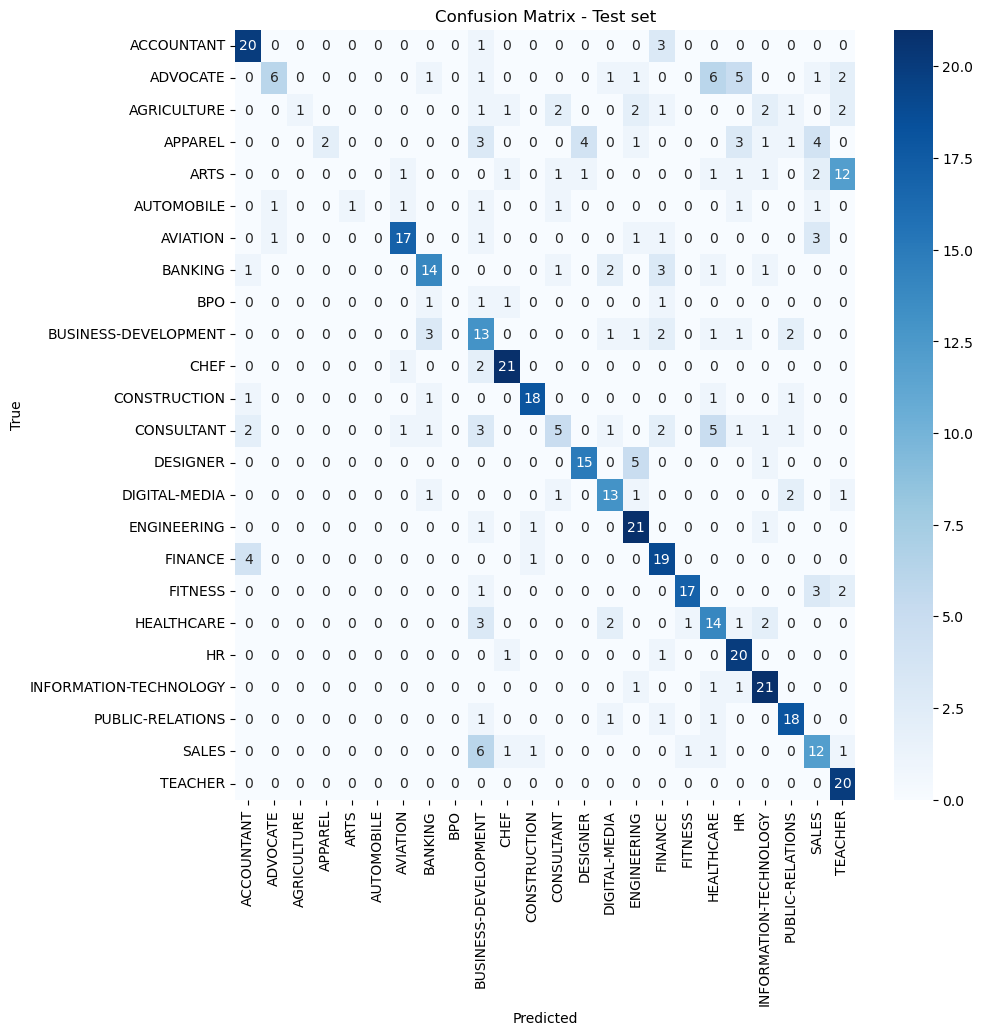

In [13]:
rf_model.evaluate_model(rf_classifier, X_test, y_test, dataset_name = 'Test set', label_encoder = label_encoder)

In [15]:
for k in range(20):
    _ = rf_model.predict_on_test_set(rf_classifier, X_test[k], y_test[k], label_encoder)

True Class: DESIGNER, Predicted Class: DESIGNER with prediction probability: 29.63%
True Class: DIGITAL-MEDIA, Predicted Class: CONSULTANT with prediction probability: 15.87%
True Class: CONSTRUCTION, Predicted Class: CONSTRUCTION with prediction probability: 25.33%
True Class: HEALTHCARE, Predicted Class: HEALTHCARE with prediction probability: 19.85%
True Class: CONSTRUCTION, Predicted Class: CONSTRUCTION with prediction probability: 12.23%
True Class: HR, Predicted Class: HR with prediction probability: 11.21%
True Class: AUTOMOBILE, Predicted Class: SALES with prediction probability: 11.10%
True Class: DIGITAL-MEDIA, Predicted Class: DIGITAL-MEDIA with prediction probability: 24.59%
True Class: ARTS, Predicted Class: SALES with prediction probability: 7.70%
True Class: DIGITAL-MEDIA, Predicted Class: DIGITAL-MEDIA with prediction probability: 31.48%
True Class: HEALTHCARE, Predicted Class: HEALTHCARE with prediction probability: 27.38%
True Class: ADVOCATE, Predicted Class: TEACHER

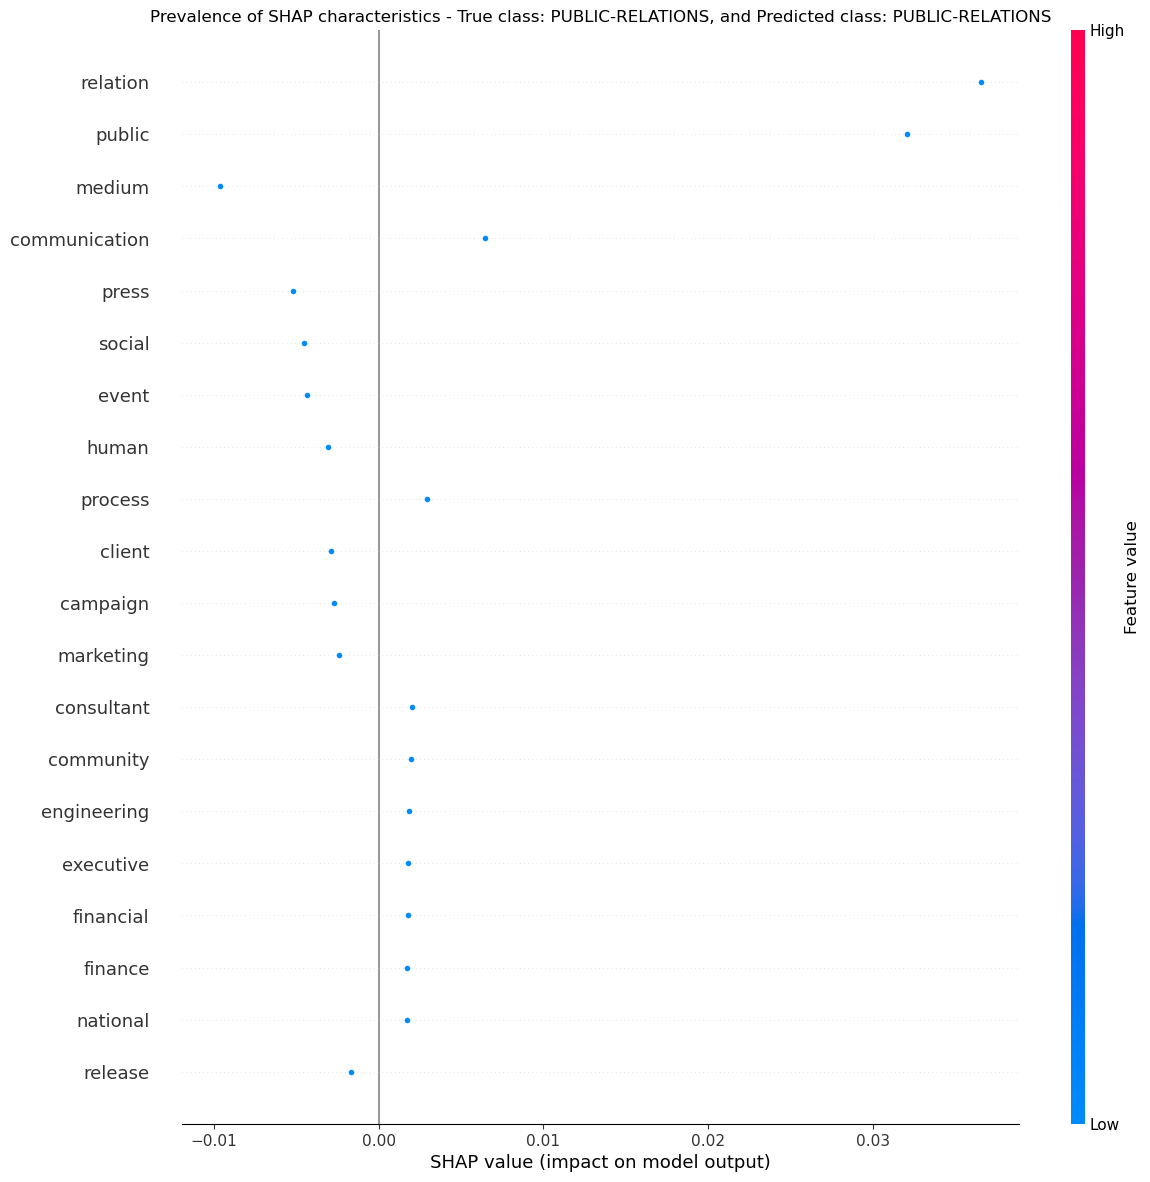

In [14]:
# from utils import rf_model
k = 302
expl_path = "models/rf_explainer.pkl"
explainer = rf_model.generate_shap_explained(rf_classifier, X_combined, explainer_path = expl_path)
# explainer = joblib.load(expl_path)
_ = rf_model.vizualize_shap_values(rf_classifier, X_test[k], y_test[k], explainer, label_encoder, tfidf_vectorizer)

# Model 2: MLP

In [15]:
import pickle
from scipy.sparse import vstack

#load optimal hyperparameters after hp tuning
a_file = open("config_hp_mlp.pkl", "rb")
params = pickle.load(a_file)
params
# folder_name = "figs"



{'hidden_layer_sizes': (64, 64),
 'activation': 'relu',
 'solver': 'adam',
 'alpha': 0.00015264326132299167,
 'tol': 0.00015806537379265087,
 'learning_rate': 'adaptive',
 'max_iter': 800}

In [18]:
# Function to train and save the Random Forest model
from sklearn.neural_network import MLPClassifier
def train_classifier(X_train, y_train, params, model_path):
    """
    Train and save a Random Forest classifier.

    Args:
    X_train, y_train: Training data and labels.
    params: Hyperparameters for the Random Forest model.
    model_path: Path to save the trained model.
    """
    mlp_classifier = MLPClassifier(random_state=0, **params) #add seed later
    print("Training...")
    mlp_classifier.fit(X_train, y_train)
    print("Done.")
    joblib.dump(mlp_classifier, model_path)
    return mlp_classifier

# Call the function with the relevant datasets and parameters
mlp_classifier = train_classifier(X_combined, y_combined, params, model_path='models/mlp_model.pkl')
# rf_classifier = joblib.load("models/rf_model.pkl")

Training...
Done.


In [ ]:
# Vizu 
rf_model.print_classification_report(mlp_classifier, X_train, y_train, label_encoder)


In [ ]:
# Vizu 
rf_model.print_classification_report(mlp_classifier, X_test, y_test, label_encoder)


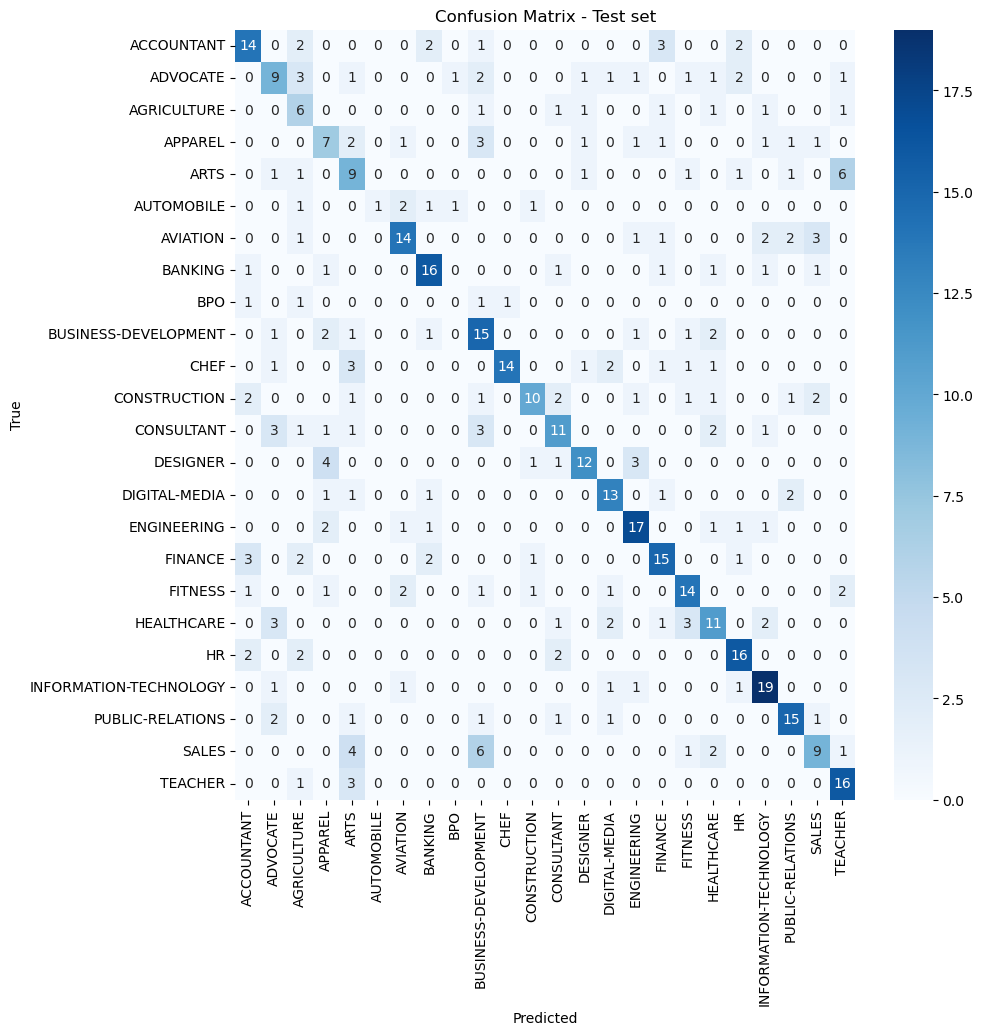

In [21]:
rf_model.evaluate_model(mlp_classifier, X_test, y_test, dataset_name = 'Test set', label_encoder = label_encoder)

In [ ]:
for k in range(20):
    _ = rf_model.predict_on_test_set(rf_classifier, X_test[k], y_test[k], label_encoder)

In [ ]:
# from utils import rf_model
k = 302
expl_path = "models/mlp_explainer.pkl"
explainer = rf_model.generate_shap_explained(mlp_classifier, X_combined, explainer_path = expl_path)
# explainer = joblib.load(expl_path)
_ = rf_model.vizualize_shap_values(rf_classifier, X_test[k], y_test[k], explainer, label_encoder, tfidf_vectorizer)

# 2. Upload the ML files to S3 bucket

In [30]:
# save pkl files in S3 bucket
file_names = ["models/" + filename + ".pkl" for filename in ["rf_model", "rf_explainer"]]
s3_keys = ["models/" + filename + ".pkl" for filename in ["rf_model", "rf_explainer"]]

for i in range(len(file_names)):
    local_file_path = file_names[i]
    s3_key = s3_keys[i]
    try:
        response = s3_client.upload_file(local_file_path, bucket_name, s3_key)
        print(f"File {local_file_path} uploaded to {bucket_name}/{s3_key}.")
    except Exception as e:
        print(f"Error occurred while uploading file: {e}")


File models/rf_model.pkl uploaded to docu-classification/models/rf_model.pkl.
File models/rf_explainer.pkl uploaded to docu-classification/models/rf_explainer.pkl.


# 3. Deploy the model - ongoing

In [ ]:
import boto3
import sagemaker
from sagemaker.sklearn.model import SKLearnModel
bucket_name = "docu-classification" # identified bucket
model_key = 'models/rf_model.pkl'  # model file path

role = sagemaker.get_execution_role()

model_data = f's3://{bucket_name}/{model_key}'
model = SKLearnModel(model_data=model_data,
                     role=role,
                     entry_point='inference.py')

# Deploy the model
predictor = model.deploy(initial_instance_count=1, instance_type='ml.m5.large')
